## Classfication of Spondylolisthesis - Machine Model Tuning and Testing Results
Michelle Ide Updated March 22 2021

#### All libraries used in this notebook are contained in the below cell

In [1]:
# General data manipulation and graphing
import pandas as pd
import numpy as np
from imblearn.pipeline import make_pipeline, Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Hyper Parameter Tuning and Upsampling
from sklearn import model_selection
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import ADASYN, SMOTE
from imblearn.combine import SMOTETomek
from sklearn.decomposition import PCA

# Scoring
from sklearn import metrics
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, recall_score

## Data
### Target (Y) and Features (X) are imported  
#### cleaning performed in separate notebook "../EDA/Spondylo_EDA.ipynb"

  
    - 309 Records
     * 6  Features
     * 1  Target
     * No Null Values
     * Quantitative Values

           0 = Normal   (209 total)  
           1 = Abnormal (100 total)

In [2]:
X = pd.read_csv('../Data/X.csv')                 # Import Features
Y = np.ravel(pd.read_csv('../Data/Y.csv'))       # Import and Reshape Target
X

,incidence,tilt,angle,slope,radius,degree
0,63.027818,22.552586,39.609117,40.475232,98.672917,-0.254400
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501
...,...,...,...,...,...,...
304,47.903565,13.616688,36.000000,34.286877,117.449062,-4.245395
305,53.936748,20.721496,29.220534,33.215251,114.365845,-0.421010
306,61.446597,22.694968,46.170347,38.751628,125.670725,-2.707880
307,45.252792,8.693157,41.583126,36.559635,118.545842,0.214750


## Split Data
### Performed a Train-Test Split, <i>stratified</i> to address imbalanced dataset, with 30% Test Set

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.3, stratify=Y,
    random_state=88)                               # Stratified, 30% test set

std_scale = StandardScaler()                       # Scale the quantitative features
X_train_scaled = std_scale.fit_transform(X_train)
X_test_scaled = std_scale.transform(X_test)

## Feature Correlation
### Examamine Feature Correlations with Seaborn Correlation plot

In [4]:
def plotCorr(data):
    corr = data.corr()
    ax = sns.heatmap(corr,
                     vmin=-1,
                     vmax=1,
                     center=0,
                     cmap=sns.diverging_palette(200, 20, n=500),
                     square=True,
                     annot=True)
    ax.set_xticklabels(ax.get_xticklabels(),
                       rotation=45,
                       horizontalalignment='right')

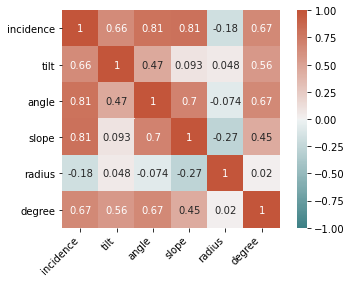

In [5]:
plotCorr(X_train)

### High correlation between some features:  Perform PCA Reduction  Selecting 99% as the variance setting.

In [6]:
pca = PCA(n_components=0.99)                   # Choose components that explain 99% of variance
X_train = pca.fit_transform(X_train_scaled)
X_test = pca.transform(X_test_scaled)
ps = pd.DataFrame(X_train)

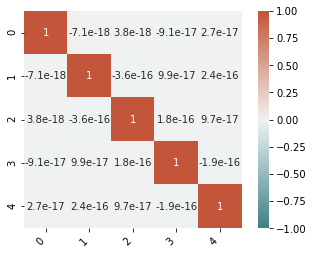

In [7]:
plotCorr(ps)

### Machine Modeling

Below, 6 Models are tuned and tested.  Selected for their strengths in classification of supervised data and differences in modeling methods, all were given various hyper parameters for testing along with two upsampling techniques to determine the best parameters and upsampling for each model.

Upsampling techniques, SMOTE-TL was selected due to it's high performance during research testing as reported by.... ADASYN was tested due to it's ability to separate boundry data through amplification of the weight in these areas.

Each model tested returned the best hyper parameters for the model with accuracy scores on each upsampling technique including:
- ROC AUC
- Confution Matrix
- Recall
- Precision
- Accuracy
- F1

For our purposes the Confusion Matrix, Recall, and Precision were used in determining the best model.  Accuracy and F1 were for overall comparisons and included for observations, not for determining best overall performance.

### Testing was performed with the following Functions:
- gridSearchCV - performs hyper parameter tuning while testing upsampling methods

- m_predictions - performs the gridsearch

- generate_roc - calculates the predict_proba for potting graphs

- plot_roc - plots AUC ROC graph of best performing hyper parameters

- plot_confusion - plots a confusion matrix when appropriate

In [8]:
# HYPER PARAMETER TUNING


def gridSearchCV(model,
                 param_grid,
                 X_train,
                 X_Test,
                 y_train,
                 y_test,
                 df_all,
                 graph=1):

    # Loop thorugh upsampling methods
    upsamples = ['SMOTE-TL', 'ADASYN']
    df_all = pd.DataFrame(columns={'Model', 'Method', 'Score'})
    for u in upsamples:
        print("\n\n\n", u)
        if u == 'SMOTE-TL':
            upsample = SMOTETomek(random_state=88)
        if u == 'ADASYN':
            upsample = ADASYN(random_state=88)

        # Call gridsearch function
        test_score, grid, predictions = m_predictions(upsample, model,
                                                      param_grid, X_train,
                                                      y_train, X_test, y_test)
        # Store scoring results
        newrow = {'Model': model, "Method": u, "Score": test_score}
        df_all = df_all.append(newrow, ignore_index=True)

        # ROC
        if graph == 1:
            generate_roc(X_test, y_test, graph, grid)
            plt.show()

        # Confusion Matrix
        plot_confusion(y_test, predictions)
        plt.show()

        # Classification Report
        report = (classification_report(y_test, predictions, output_dict=True))
        print(classification_report(y_test, predictions))

        # Print parameters
        print("Best Parameters: ", grid.best_params_)

    # Return scores
    return df_all

In [9]:
# MODEL PREDICTIONS


def m_predictions(upsample, model, param_grid, X_train_scaled, y_train,
                  X_test_scaled, y_test):

    # Fold used for GridSearchCV
    kf = KFold(n_splits=5, shuffle=False)

    # Create pipeline
    pipeline = Pipeline([('sampling', upsample), ('class', model)])

    # Gridsearch - fit - predict
    grid = GridSearchCV(pipeline, param_grid, scoring='accuracy', cv=kf)
    grid.fit(X_train_scaled, y_train)
    predictions = grid.predict(X_test_scaled)
    
    # Test
    test_score = grid.score(X_test_scaled, y_test)
    
    # Return Scores, grid, and predictions for use in reports and graphs
    return test_score, grid, predictions

In [10]:
# Generate ROC

def generate_roc(X_test_scaled, y_test, graph, grid):
    proba_predict = grid.predict_proba(X_test_scaled)
    preds = proba_predict[:, 1]
    plot_ROC(grid, preds, X_test_scaled, y_test, graph=graph)  # Plot ROC graph

In [11]:
# Plots the ROC

def plot_ROC(model, probs, test_features, test_target, graph=1):
    if graph == 1:
        print("area under curve (auc): ", metrics.roc_auc_score(y_test, probs))
        fpr, tpr, thresholds = roc_curve(test_target, probs)
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.plot(fpr, tpr)

In [12]:
# Plots confusion matrix of model

def plot_confusion(y_test, pred):
    mat = confusion_matrix(y_test, pred)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.xlabel('true label')
    plt.ylabel('predicted label')

In [13]:
score_sum = pd.DataFrame(columns = {'Model', 'Method', 'Score'})       # df will collect all accuracy scores

### Test Steps : 

 1. Hyper Parameters to be tested placed in dictionary for gridSearch
 2. Perform GridSearch on parameter grid - returns scores for each upsampling method, prints all scores
 3. Store accuracy scores for each model & upsampling method in dataframe named 'score_sum'

### LOGISTIC REGRESSION




 SMOTE-TL
area under curve (auc):  0.9507936507936507


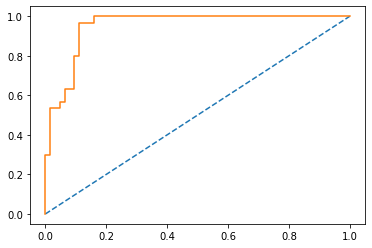

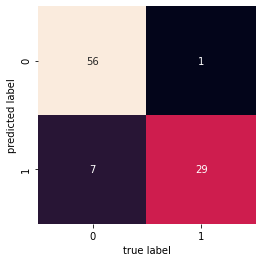

              precision    recall  f1-score   support

           0       0.98      0.89      0.93        63
           1       0.81      0.97      0.88        30

    accuracy                           0.91        93
   macro avg       0.89      0.93      0.91        93
weighted avg       0.93      0.91      0.92        93

Best Parameters:  {'class__C': 10, 'class__penalty': 'l2', 'class__solver': 'newton-cg'}



 ADASYN
area under curve (auc):  0.9560846560846561


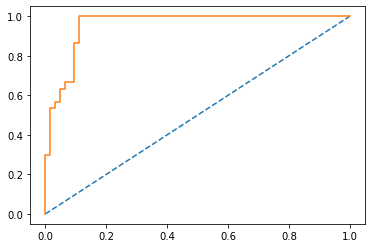

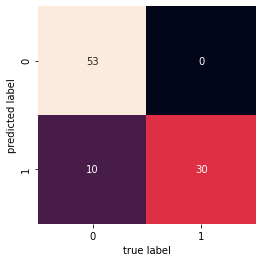

              precision    recall  f1-score   support

           0       1.00      0.84      0.91        63
           1       0.75      1.00      0.86        30

    accuracy                           0.89        93
   macro avg       0.88      0.92      0.89        93
weighted avg       0.92      0.89      0.90        93

Best Parameters:  {'class__C': 10, 'class__penalty': 'l2', 'class__solver': 'newton-cg'}


In [14]:
# Hyper Parameters to be tested placed in dictionary for gridSearch
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag']
penalty = ['l2']
c_values = [0.001, 0.01, 0.1, 1, 10]
random_grid = {
    'class__solver': solvers,
    'class__penalty': penalty,
    'class__C': c_values
}

# Perform GridSearch on parameter grid
lg_all_scores = gridSearchCV(LogisticRegression(random_state=42),
                             random_grid,
                             X_train,
                             X_test_scaled,
                             y_train,
                             y_test,
                             score_sum,
                             graph=1)

# Add the scores
score_sum = score_sum.append(lg_all_scores)

In [15]:
print(score_sum)

                                 Model    Method     Score
0  LogisticRegression(random_state=42)  SMOTE-TL  0.913978
1  LogisticRegression(random_state=42)    ADASYN  0.892473


## GRADIENT BOOSTING CLASSIFIER




 SMOTE-TL
area under curve (auc):  0.9380952380952381


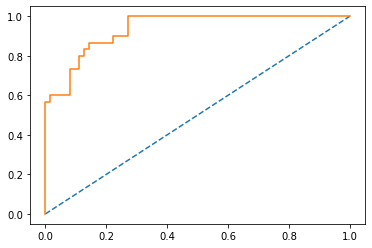

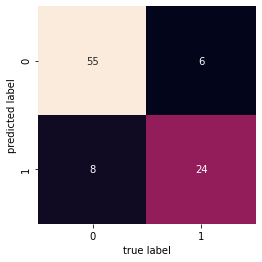

              precision    recall  f1-score   support

           0       0.90      0.87      0.89        63
           1       0.75      0.80      0.77        30

    accuracy                           0.85        93
   macro avg       0.83      0.84      0.83        93
weighted avg       0.85      0.85      0.85        93

Best Parameters:  {'class__criterion': 'friedman_mse', 'class__learning_rate': 0.2, 'class__loss': 'exponential', 'class__n_estimators': 36}



 ADASYN
area under curve (auc):  0.9058201058201059


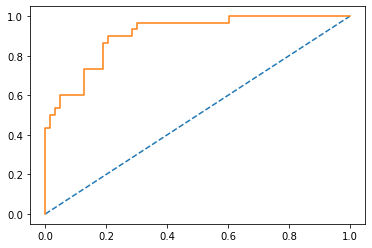

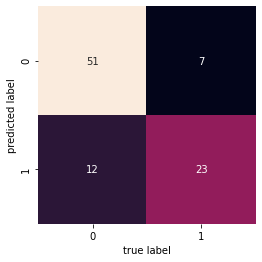

              precision    recall  f1-score   support

           0       0.88      0.81      0.84        63
           1       0.66      0.77      0.71        30

    accuracy                           0.80        93
   macro avg       0.77      0.79      0.78        93
weighted avg       0.81      0.80      0.80        93

Best Parameters:  {'class__criterion': 'friedman_mse', 'class__learning_rate': 0.8, 'class__loss': 'exponential', 'class__n_estimators': 51}


In [16]:
# Hyper Parameters to be tested placed in dictionary for gridSearch
loss = ['deviance', 'exponential']
lr = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
ne = range(1, 100, 5)
cr = ['friedman_mse', 'mse', 'mae']
random_grid = {
    'class__loss': loss,
    'class__learning_rate': lr,
    'class__n_estimators': ne,
    'class__criterion': cr
}

# Perform GridSearch on parameter grid
gb_all_score = gridSearchCV(GradientBoostingClassifier(random_state=42),
                            random_grid, X_train, X_test, y_train, y_test,
                            score_sum)

# Add the scores to summary
score_sum = score_sum.append(gb_all_score)

In [17]:
score_sum = score_sum.append(gb_all_score)
print(score_sum)

                                         Model    Method     Score
0          LogisticRegression(random_state=42)  SMOTE-TL  0.913978
1          LogisticRegression(random_state=42)    ADASYN  0.892473
0  GradientBoostingClassifier(random_state=42)  SMOTE-TL  0.849462
1  GradientBoostingClassifier(random_state=42)    ADASYN  0.795699
0  GradientBoostingClassifier(random_state=42)  SMOTE-TL  0.849462
1  GradientBoostingClassifier(random_state=42)    ADASYN  0.795699


## SUPPORT VECTOR MACHINE




 SMOTE-TL


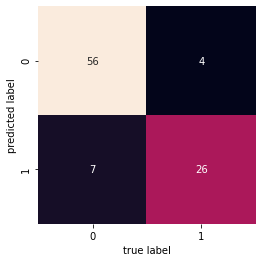

              precision    recall  f1-score   support

           0       0.93      0.89      0.91        63
           1       0.79      0.87      0.83        30

    accuracy                           0.88        93
   macro avg       0.86      0.88      0.87        93
weighted avg       0.89      0.88      0.88        93

Best Parameters:  {'class__C': 1000, 'class__gamma': 0.01, 'class__kernel': 'rbf'}



 ADASYN


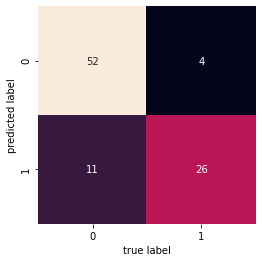

              precision    recall  f1-score   support

           0       0.93      0.83      0.87        63
           1       0.70      0.87      0.78        30

    accuracy                           0.84        93
   macro avg       0.82      0.85      0.83        93
weighted avg       0.86      0.84      0.84        93

Best Parameters:  {'class__C': 10, 'class__gamma': 0.1, 'class__kernel': 'rbf'}


In [18]:
param_grid = {
    'class__C': [0.1, 1, 10, 100, 1000],
    'class__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'class__kernel': ['rbf']
}

# Perform GridSearch on parameter grid
svm_all_scores = gridSearchCV(SVC(random_state=42),
                              param_grid,
                              X_train,
                              X_test,
                              y_train,
                              y_test,
                              score_sum,
                              graph=2)
# Add the scores to summary0
score_sum = score_sum.append(svm_all_scores)

## RANDOM FOREST CLASSIFIER




 SMOTE-TL
area under curve (auc):  0.8500000000000001


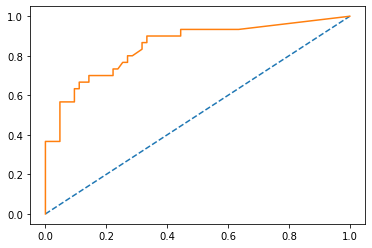

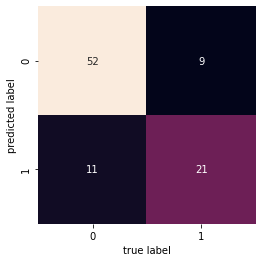

              precision    recall  f1-score   support

           0       0.85      0.83      0.84        63
           1       0.66      0.70      0.68        30

    accuracy                           0.78        93
   macro avg       0.75      0.76      0.76        93
weighted avg       0.79      0.78      0.79        93

Best Parameters:  {'class__criterion': 'entropy', 'class__max_depth': 7, 'class__min_samples_leaf': 5, 'class__n_estimators': 4}



 ADASYN
area under curve (auc):  0.8566137566137566


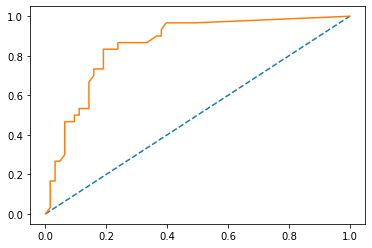

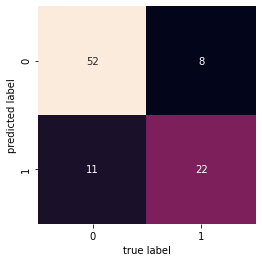

              precision    recall  f1-score   support

           0       0.87      0.83      0.85        63
           1       0.67      0.73      0.70        30

    accuracy                           0.80        93
   macro avg       0.77      0.78      0.77        93
weighted avg       0.80      0.80      0.80        93

Best Parameters:  {'class__criterion': 'entropy', 'class__max_depth': 8, 'class__min_samples_leaf': 2, 'class__n_estimators': 4}


In [19]:
param_grid = {
    'class__n_estimators': [1, 2, 4, 8, 16, 32, 64, 100, 200],
    'class__max_depth': range(1, 32, 1),
    'class__min_samples_leaf': [1, 2, 3, 4, 5],
    'class__criterion': ['gini', 'entropy']
}

# Perform GridSearch on parameter grid
RF_all_scores = gridSearchCV(RandomForestClassifier(random_state=42),
                             param_grid, X_train, X_test, y_train, y_test,
                             score_sum)

# Add the scores to summary
score_sum = score_sum.append(RF_all_scores)

## KNEIGHBORS CLASSIFIER

#### Base Measure without tuning




 SMOTE-TL
area under curve (auc):  0.8417989417989418


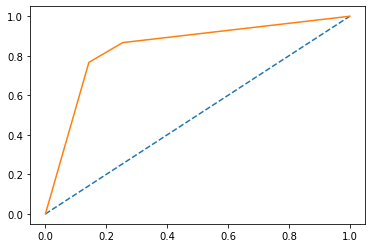

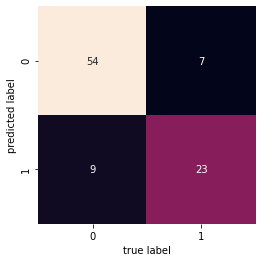

              precision    recall  f1-score   support

           0       0.89      0.86      0.87        63
           1       0.72      0.77      0.74        30

    accuracy                           0.83        93
   macro avg       0.80      0.81      0.81        93
weighted avg       0.83      0.83      0.83        93

Best Parameters:  {'class__algorithm': 'auto', 'class__leaf_size': 1, 'class__n_neighbors': 2, 'class__p': 1, 'class__weights': 'uniform'}



 ADASYN
area under curve (auc):  0.8526455026455027


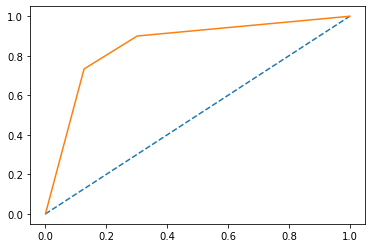

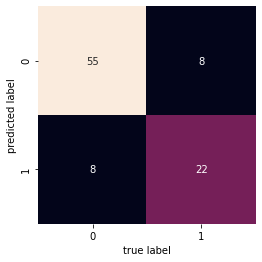

              precision    recall  f1-score   support

           0       0.87      0.87      0.87        63
           1       0.73      0.73      0.73        30

    accuracy                           0.83        93
   macro avg       0.80      0.80      0.80        93
weighted avg       0.83      0.83      0.83        93

Best Parameters:  {'class__algorithm': 'auto', 'class__leaf_size': 1, 'class__n_neighbors': 2, 'class__p': 2, 'class__weights': 'uniform'}


In [20]:
param_grid = {
    'class__algorithm': ['auto'],
    'class__leaf_size': [1, 5, 10, 15, 20, 25, 30],
    'class__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8],
    'class__p': [1, 2],
    'class__weights': ['uniform', 'distance']
}

# Perform GridSearch on parameter grid
KN_all_scores = gridSearchCV(KNeighborsClassifier(), param_grid, X_train,
                             X_test, y_train, y_test, score_sum)

# Add the scores to summary
score_sum = score_sum.append(KN_all_scores)

### Gaussian Naive Bayes




 SMOTE-TL
area under curve (auc):  0.8915343915343916


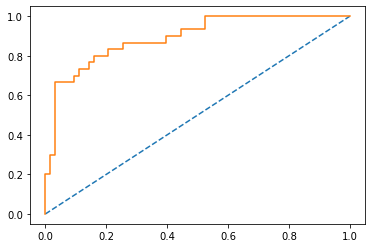

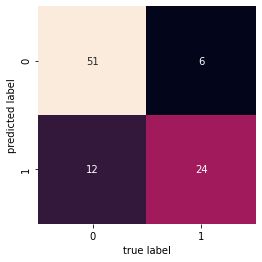

              precision    recall  f1-score   support

           0       0.89      0.81      0.85        63
           1       0.67      0.80      0.73        30

    accuracy                           0.81        93
   macro avg       0.78      0.80      0.79        93
weighted avg       0.82      0.81      0.81        93

Best Parameters:  {'class__var_smoothing': 1e-09}



 ADASYN
area under curve (auc):  0.8629629629629629


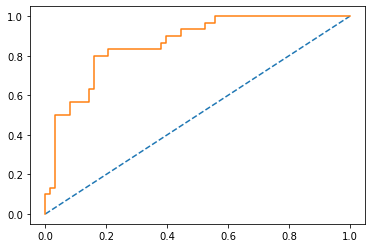

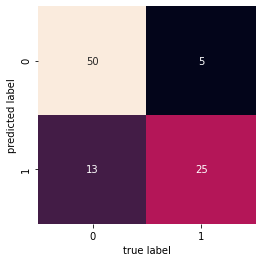

              precision    recall  f1-score   support

           0       0.91      0.79      0.85        63
           1       0.66      0.83      0.74        30

    accuracy                           0.81        93
   macro avg       0.78      0.81      0.79        93
weighted avg       0.83      0.81      0.81        93

Best Parameters:  {'class__var_smoothing': 1e-09}


,Model,Method,Score
0,LogisticRegression(random_state=42),SMOTE-TL,0.913978
1,LogisticRegression(random_state=42),ADASYN,0.892473
0,GradientBoostingClassifier(random_state=42),SMOTE-TL,0.849462
1,GradientBoostingClassifier(random_state=42),ADASYN,0.795699
0,GradientBoostingClassifier(random_state=42),SMOTE-TL,0.849462
1,GradientBoostingClassifier(random_state=42),ADASYN,0.795699
0,SVC(random_state=42),SMOTE-TL,0.881720
1,SVC(random_state=42),ADASYN,0.838710
0,RandomForestClassifier(random_state=42),SMOTE-TL,0.784946
1,RandomForestClassifier(random_state=42),ADASYN,0.795699


In [21]:
param_grid = {'class__var_smoothing': [1e-1, 1e-9, 1e-19, 1e-29]}

# Perform GridSearch on parameter grid
GB_all_scores = gridSearchCV(GaussianNB(priors=None, ), param_grid, X_train,
                             X_test, y_train, y_test, score_sum)

# Add the scores to summary
score_sum.append(GB_all_scores)

In [22]:
# Accuracy Scores Summary
print(score_sum.sort_values(by="Score", ascending = False))

                                         Model    Method     Score
0          LogisticRegression(random_state=42)  SMOTE-TL  0.913978
1          LogisticRegression(random_state=42)    ADASYN  0.892473
0                         SVC(random_state=42)  SMOTE-TL  0.881720
0  GradientBoostingClassifier(random_state=42)  SMOTE-TL  0.849462
0  GradientBoostingClassifier(random_state=42)  SMOTE-TL  0.849462
1                         SVC(random_state=42)    ADASYN  0.838710
0                       KNeighborsClassifier()  SMOTE-TL  0.827957
1                       KNeighborsClassifier()    ADASYN  0.827957
1  GradientBoostingClassifier(random_state=42)    ADASYN  0.795699
1  GradientBoostingClassifier(random_state=42)    ADASYN  0.795699
1      RandomForestClassifier(random_state=42)    ADASYN  0.795699
0      RandomForestClassifier(random_state=42)  SMOTE-TL  0.784946


### Results

#### Summary

Six well-known classification models were tested using 70% of the data to train and 30% to test.  A large range of potential hyper parameter settings were tested for each model,  determining the best settings for this project.  Each model was selected due to it's usefulness in classification problems and it's differences in algorithmic process compared to the remaining models.  

#### Models
When comparing results, this algorithmic process was taken into account, given the nature of the data.  Three models performed similarly with the Logistic Regression performing 5% higher than the Gradient Boosting and Support Vector Machine.   The linear nature of the Logistic Regression is not as reliable when dealing with extreme, sparse, values making the remaining 2 algorithms a good first choice.  The Gradient Boosting algorithm is extremely slow on just 309 samples and may be undesirable with large amounts of data, depending on the hardware used.  The Support Vector Machine, similar to Logistic Regression in accuracy with a 3% difference, would provide the flexible boundaries needed to absorb infrequent extremes without dragging the center population down in precision.  

#### Upsampling & Imbalanced Data
The nature of this project expects the data to be continuously imbalanced.  The technique of handling these is therefore important to test and select based on the sensitivity needs, number of false negatives compared to false positives and the cost associated.

Using the ADASYN upsampling method:
Out of 100 samples, 10 will be false positive ( Abnormal ), and 0 will be false negative ( Normal )

Using SMOTE-TL:
Out of 100 samples, 7 will be false positive ( Abnormal ) and 1 will be false negative ( Normal )


#### Recommendation

I recommend Support Vector Machine with either ADASYN or SMOTE-TL method for upsampling.  The choice between these two methods depends on the sensitivity requirements for false negatives and positives.

Using ADASYN it can be expected to have rarely, if ever,  false negative results, there will however be 3 more false positive contained in every 100 samples.

My past experience in healthcare research leads me to lean toward ADASYN and avoid false negatives.  However, 10 out of 100 false positives could reduce confidence in results and lead to additional costs in follow-up testing.  This decision betweenn the 2 sampling methods would require feedback from decision makers.


### Future Development

Future improvements:
- Test several stacking methods to search for improved accuracy - this would provide additional layers of testing results to verify.

- Test and train on more data, 309 samples is not bad to start but much more would be needed to validate results condidently.

- Create unique splits to data prior to train-test split to test sparse data processing for small radiology departments with fewer results to run.